In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
#export
from exp.nb_10c import *

# Imagenette training

In [3]:
path = untar_data(imagenette_160); path

PosixPath('/home/ubuntu/learnai/dl/data/imagenette-160')

In [4]:
size = 128
tfms = [make_rgb, RandomResizedCrop(128, scale=(0.35, 1)), np_to_float, PilRandomFlip()]
bs = 32
il = ImageList.from_files(path, tfms=tfms)
sd = SplitData.split_by_func(il, partial(grandparent_splitter, valid_name='val'))
ll = label_by_func(sd, parent_labeler)

ll.valid.x.tfms = [make_rgb, CenterCrop(size), np_to_float]

data = ll.to_databunch(bs, c_in=3, c_out=10, num_workers=8)

# XResNet

In [5]:
#export
def noop(x):
    return x

class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)
    
def conv(ni, nf, ks=3, stride=1, bias=False):
    return nn.Conv2d(ni, nf, kernel_size=ks, stride=stride, padding=ks//2, bias=bias)

In [6]:
#export
act_fn = nn.ReLU(inplace=True)

def init_cnn(m):
    if getattr(m, 'bias', None) is not None:
        nn.init.constant_(m.bias, 0)
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        nn.init.kaiming_normal_(m.weight)
        
    for l in m.children():
        init_cnn(l)
        
def conv_layer(ni, nf, ks=3, stride=1, zero_bn=False, act=True):
    bn = nn.BatchNorm2d(nf)
    nn.init.constant_(bn.weight, 0. if zero_bn else 1.)
    layers = [conv(ni, nf, ks, stride=stride), bn]
    if act:
        layers.append(act_fn)
    return nn.Sequential(*layers)

In [7]:
#export
class ResBlock(nn.Module):
    def __init__(self, expansion, ni, nh, stride=1):
        super().__init__()
        nf, ni = nh*expansion, ni*expansion
        layers = [conv_layer(ni, nh, 1)]
        layers += [
            conv_layer(nh, nf, 3, stride=stride, zero_bn=True, act=False)
        ] if expansion==1 else [
            conv_layer(nh, nh, 3, stride=stride),
            conv_layer(nh, nf, 1, zero_bn=True, act=False)            
        ]
        self.convs = nn.Sequential(*layers)
        self.idconv = noop if ni==nf else conv_layer(ni, nf, 1, act=False)
        self.pool = noop if stride==1 else nn.AvgPool2d(2)
        
    def forward(self, x):
        return act_fn(self.convs(x) + self.idconv(self.pool(x)))

In [8]:
#export
class XResNet(nn.Sequential):
    @classmethod
    def create(cls, expansion, layers, c_in=3, c_out=1000):
        nfs = [c_in, (c_in+1)*8, 64, 64]
        stem = [conv_layer(nfs[i], nfs[i+1], stride=2 if i==0 else 1) for i in range(3)]
        
        nfs = [64//expansion, 64, 128, 256, 512]
        res_layers = [cls._make_layer(expansion, nfs[i], nfs[i+1],
                                     n_blocks=1, stride=1 if i==0 else 2)
                     for i, l in enumerate(layers)]
        
        res = cls(*stem, nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
                 *res_layers, nn.AdaptiveAvgPool2d(1), Flatten(),
                 nn.Linear(nfs[-1] * expansion, c_out))
        
        init_cnn(res)
        return res
    
    @staticmethod
    def _make_layer(expansion, ni, nf, n_blocks, stride):
        return nn.Sequential(*[ResBlock(expansion, ni if i==0 else nf, nf, stride if i==0 else 1) for i in range(n_blocks)])

In [9]:
#export
def xresnet18(**kwargs):
    return XResNet.create(1, [2, 2, 2, 2], **kwargs)

def xresnet34(**kwargs):
    return XResNet.create(1, [3, 4, 6, 3], **kwargs)

def xresnet50(**kwargs):
    return XResNet.create(4, [3, 4, 6, 3], **kwargs)

def xresnet101(**kwargs):
    return XResNet.create(4, [3, 4, 23, 3], **kwargs)

def xresnet152(**kwargs):
    return XResNet.create(4, [3, 8, 36, 3], **kwargs)


## Train

In [10]:
cbfs = [partial(AvgStatsCallback, accuracy),
       ProgressCallback,
       CudaCallback,
       partial(BatchTransformXCallback, norm_imagenette),
       partial(MixUp, alpha=0.2)]

In [33]:
#export
def adam_opt(xtra_step=None, **kwargs):
    return partial(StatefulOptimizer, steppers=[adam_step,weight_decay]+listify(xtra_step),
                   stats=[AverageGrad(dampening=True), AverageSqrGrad(), StepCount()], **kwargs)

In [12]:
loss_func = LabelSmoothingCrossEntropy()
arch = partial(xresnet18, c_out=10)
opt_func = adam_opt(mom=0.9, mom_sqr=0.99, eps=1e-6, wd=1e-2)

In [13]:
#export
def get_batch(dl, learn):
    learn.xb, learn.yb = next(iter(dl))
    learn.do_begin_fit(0)
    learn('begin_batch')
    learn('after_fit')
    return learn.xb, learn.yb

In [14]:
#export
def model_summary(model, find_all=False, print_mod=False):
    xb, yb = get_batch(data.valid_dl, learn)
    mods = find_modules(model, is_lin_layer) if find_all else model.children()
    f = lambda hook, mod, inp, out: print(f'====\n{mod}\n' if print_mod else '', out.shape)
    with Hooks(mods, f) as hooks:
        learn.model(xb)

In [15]:
learn = Learner(arch(), data, loss_func, lr=1, cb_funcs=cbfs, opt_func=opt_func)

In [16]:
learn.model = learn.model.cuda()

In [17]:
model_summary(learn.model, print_mod=True)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time


====
Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
)
 torch.Size([64, 32, 64, 64])
====
Sequential(
  (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
)
 torch.Size([64, 64, 64, 64])
====
Sequential(
  (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
)
 torch.Size([64, 64, 64, 64])
====
MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
 torch.Size([64, 64, 32, 32])
====
Sequential(
  (0): ResBlock(
    (convs): Sequential(
      (0): Sequential(
        (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=

In [18]:
arch = partial(xresnet34, c_out=10)

In [19]:
learn = Learner(arch(), data, loss_func, lr=1, cb_funcs=cbfs, opt_func=opt_func)

In [20]:
#export
class LR_Find(Callback):
    _order=1
    def __init__(self, max_iter=100, min_lr=1e-6, max_lr=10):
        self.max_iter,self.min_lr,self.max_lr = max_iter,min_lr,max_lr
        self.best_loss = 1e9

    def begin_batch(self):
        if not self.in_train: return
        pos = self.n_iter/self.max_iter
        lr = self.min_lr * (self.max_lr/self.min_lr) ** pos
        for pg in self.opt.hypers: pg['lr'] = lr

    def after_step(self):
        if self.n_iter>=self.max_iter or self.loss>self.best_loss*10:
            raise CancelTrainException()
        if self.loss < self.best_loss: self.best_loss = self.loss

In [21]:
learn.fit(1, cbs=[LR_Find(), Recorder()])

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time


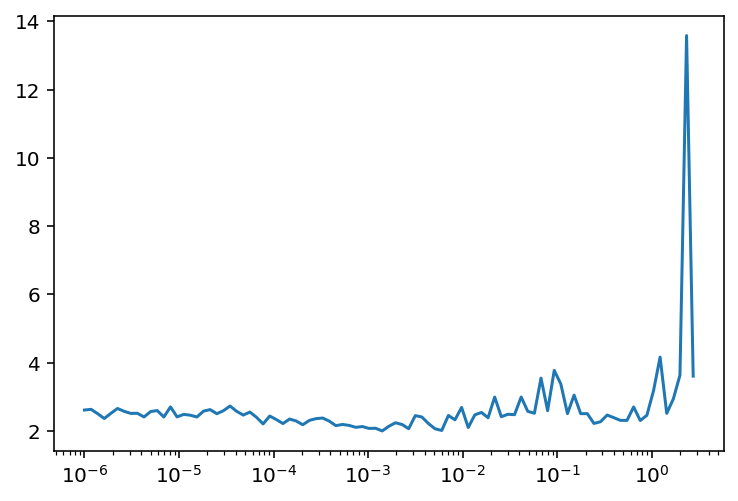

In [22]:
learn.recorder.plot(3)

In [23]:
#export
def create_phases(phases):
    phases = listify(phases)
    return phases + [1-sum(phases)]

In [24]:
print(create_phases(0.3))
print(create_phases([0.3, 0.2]))

[0.3, 0.7]
[0.3, 0.2, 0.5]


In [25]:
lr = 1e-2
pct_start = 0.5
phases = create_phases(pct_start)
sched_lr = combine_scheds(phases, cos_1cycle_anneal(lr/10., lr, lr/1e5))
sched_mom = combine_scheds(phases, cos_1cycle_anneal(0.95, 0.85, 0.95))

In [26]:
cbsched = [
    ParamScheduler('lr', sched_lr),
    ParamScheduler('mom', sched_mom)
]

In [27]:
learn = Learner(arch(), data, loss_func, lr=lr, cb_funcs=cbfs, opt_func=opt_func)

In [28]:
learn.fit(5, cbs=cbsched)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,1.936438,0.418644,1.956729,0.392000,00:41
1,1.788530,0.502249,1.820869,0.416000,00:41
2,1.677781,0.571584,1.531700,0.560000,00:41
3,1.527044,0.647433,1.120411,0.752000,00:41
4,1.409843,0.714441,1.032361,0.800000,00:41


In [29]:
#export
def cnn_learner(arch, data, loss_func, opt_func, c_in=None, c_out=None,
               lr=1e-2, cuda=True, norm=None, progress=True, mixup=0, xtra_cb=None, **kwargs):
    cbfs = [partial(AvgStatsCallback, accuracy)]+listify(xtra_cb)
    if progress:
        cbfs.append(ProgressCallback)
    if cuda:
        cbfs.append(CudaCallback)
    if norm:
        cbfs.append(partial(BatchTransformXCallback, norm))
    if mixup:
        cbfs.append(partial(MixUp, mixup))
    arch_args = {}
    if not c_in:
        c_in = data.c_in
    if not c_out:
        c_out = data.c_out
    if c_in:
        arch_args['c_in'] = c_in
    if c_out:
        arch_args['c_out'] = c_out
    return Learner(arch(**arch_args), data, loss_func, opt_func=opt_func, lr=lr, cb_funcs=cbfs, **kwargs)

In [30]:
learn = cnn_learner(xresnet34, data, loss_func, opt_func, norm=norm_imagenette)

In [31]:
learn.fit(5, cbsched)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,1.759996,0.462153,1.671496,0.498000,00:41
1,1.550175,0.566930,1.850042,0.464000,00:41
2,1.411909,0.629595,1.310519,0.644000,00:41
3,1.240580,0.698154,1.163182,0.740000,00:41
4,1.093180,0.769350,0.966980,0.816000,00:41


# Export

In [34]:
!python notebook2script.py 11_train_imagenette.ipynb

converted 11_train_imagenette.ipynb to nb_11.py
